### CAUTION
This notebook is for experimentation only and is not meant to be used for anything practical

In [2]:
# Generic imports, plus some custom setting of the "path"
# to make possible running with a slightly non-compliant Python install
# which may miss lzma

import  os, pickle, time
import  numpy as np
import  matplotlib.pyplot as plt
from    mpl_toolkits import mplot3d
from    scipy.spatial.transform import Rotation as R
from    scipy import interpolate
from    scipy.interpolate import interp1d

import  sys
sys.path.insert(0, '/home/maxim/.virtualenvs/lusee/lib/python3.10/site-packages/backports.lzma-0.0.14-py3.10-linux-x86_64.egg/backports')
sys.path.append('/home/maxim/projects/lusee/luseepy/')
import lusee 

In [14]:

# Testing Julian dates and intervals
from datetime import datetime, timedelta, timezone
dt_Offset = 2400000.500
juliandate = 2459168.298
dt = datetime(1858, 11, 17, tzinfo=timezone.utc) + timedelta(juliandate-dt_Offset)
print(dt)

mjd = 6.071000000000000000e+04

dt = datetime(1858, 11, 17, tzinfo=timezone.utc) + timedelta(mjd)
print(dt)

mjd = 6.074198958333333576e+04

dt = datetime(1858, 11, 17, tzinfo=timezone.utc) + timedelta(mjd)
print(dt)


2020-11-14 19:09:07.199996+00:00
2025-02-04 00:00:00+00:00
2025-03-07 23:45:00+00:00


In [23]:
import lusee
from lusee import Observation as O

o = O("2025-02-04 00:00:00 to 2025-03-07 23:45:00")
print(len(o.times))

track = o.get_track_solar('sun')
alt = track[0]
az  = track[1]

for i in range(10):
    print(alt[i])

f = open("alt.txt", "w")
for a in alt: f.write(str(a)+'\n')
f.close()

print("done")


3072
0.26965922840149836
0.2676433533254563
0.26562729975905996
0.2636110696941546
0.26159466511533763
0.25957808799920773
0.2575613403161006
0.25554442402933775
0.2535273410952994
0.25151009346350606
done


_altaz2xyz_:  function that converts from altitude and azimuth coordinates to Cartesian coordinates, for ease of angle calculations and plotting.

In [2]:
def altaz2xyz(alt,az):   
    sun = np.zeros((len(alt),3))
    sun[:,0] = np.cos(alt) * np.sin(az)
    sun[:,1] = np.cos(alt) * np.cos(az)
    sun[:,2] = np.sin(alt)
              
    return sun

3072
3072


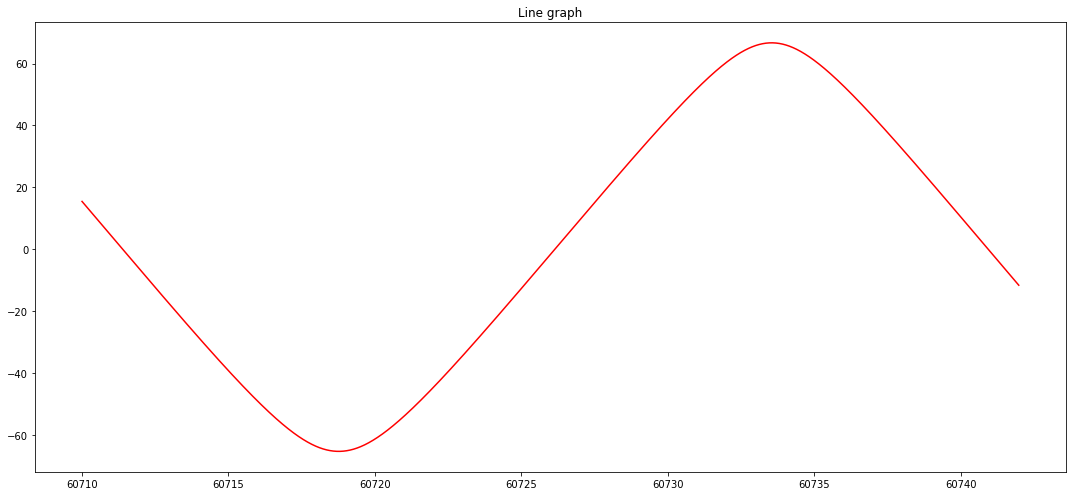

[275.7860424  275.73184909 275.677711   ... 264.59236383 264.53924409
 264.48607977]


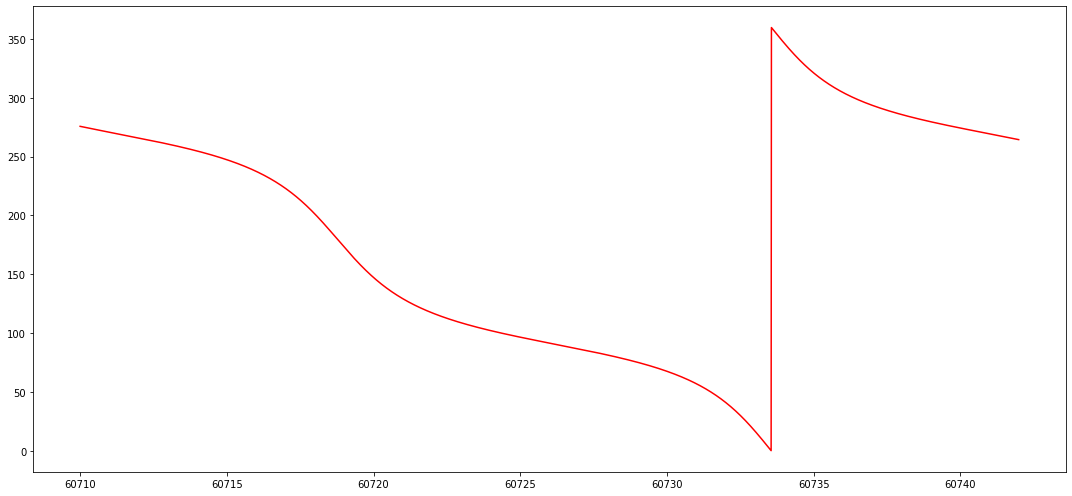

In [8]:
import lusee
alt = np.loadtxt('alt_fullday.txt')
# print(alt)
plt.rcParams["figure.figsize"] = [15., 7.]
plt.rcParams["figure.autolayout"] = True

y = np.array(alt)
print(y.size)

x = np.loadtxt('mjd_fullday.txt') # np.arange(0, y.size, 1)

print(x.size)

plt.title("Line graph")
plt.plot(x, y, color="red")

plt.show()

az = np.loadtxt('az_fullday.txt')
print(az)
plt.plot(x, np.array(az), color="red")

plt.show()

0.26965922840149836
0.2676433533254563
0.26562729975905996


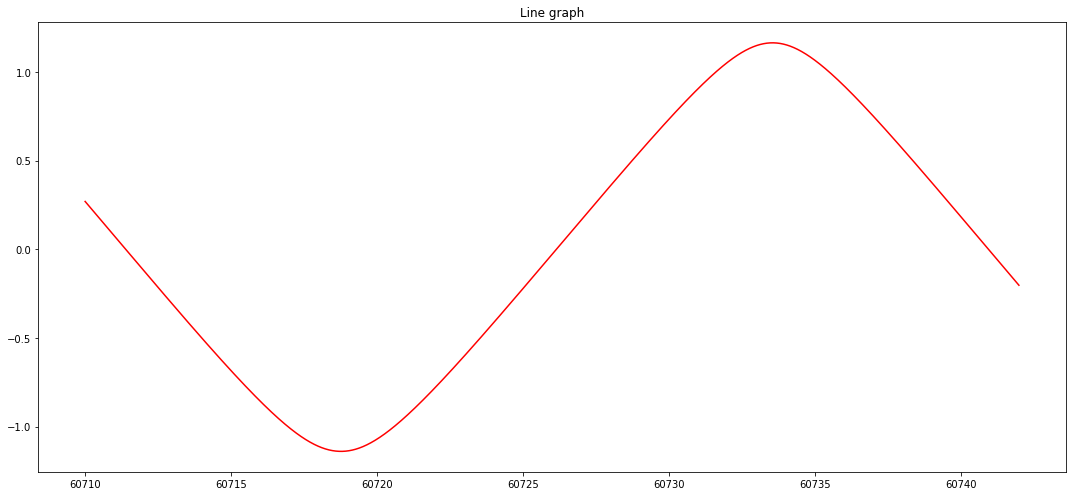

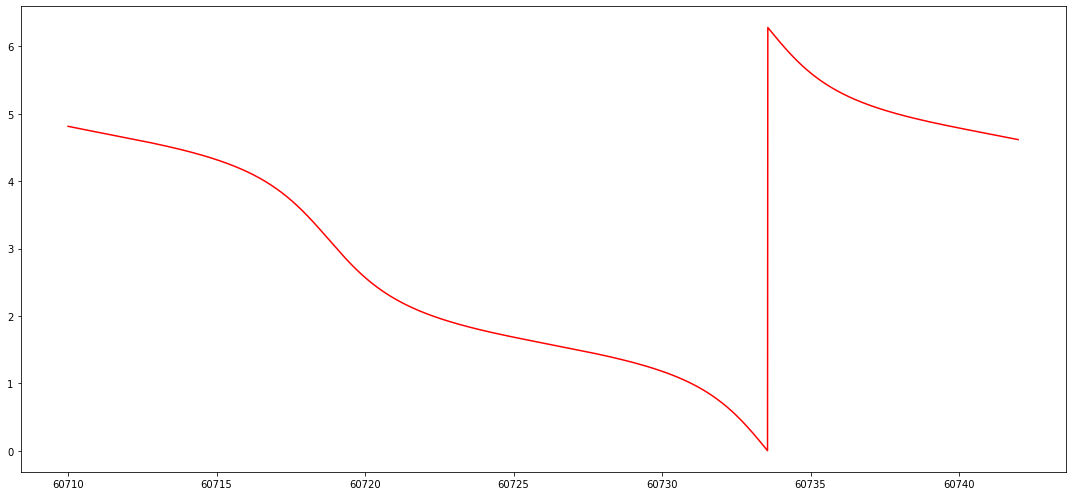

In [5]:
import lusee
import numpy as np
from lusee import Observation as O

interval = "2025-02-04 00:00:00 to 2025-03-07 23:45:00"
o = O(interval)

(alt, az) = o.get_track_solar('sun')
y = np.array(alt)

for i in range(3):
    print(y[i])

length = o.times.size

x = np.empty(length)

for i in range(length):
    x[i] = o.times[i].mjd

plt.rcParams["figure.figsize"] = [15., 7.]
plt.rcParams["figure.autolayout"] = True

plt.title("Line graph")
plt.plot(x, y, color="red")
plt.show()

y = np.array(az)
plt.plot(x, y, color="red")
plt.show()

### def PVProjArea(pv_tilt_angle=0, E_area=1, W_area=1, T_area=1, horizon=0.0, lander_pitch=0, lander_roll=0, lander_yaw=0)

A function that calculates the projected area of all three photovoltaic (PV) panels, on the top, east, and west faces of LuSEE. Inputs are:
  1. pv_tilt_angle: Specifies the normal angle of the E and W face panels, with respect to horizontal. Positive angles are up. Basically deprecated now, the E&W panels will have pv_tilt_angle=0.
  2. E_area: Area of the east panel. I used to input areas in m^2, Paul now uses 1 here, and multiplies by the physical area later.
  3. W_area: Area of the west panel.
  4. T_area: Area of the top panel.
  v) horizon: cutoff elevation angle for the horizon. Usually zero, but could set higher to account for local geographical features.
  vi) lander_pitch: Rotational angle for lander, angles in degrees. Lander is defined to have "nose" pointing N. Pitch is rotation around E-W axis, + is nose down, - is nose up
  vii) lander_roll: Rotation around N-S axis, + is top rotating left, - is top rotating right
  viii) lander_yaw: Rotation around vertical axis, + is nose right, - is nose left

Function defines normal vectors for each face, rotates by the lander angles, calculates dot product with solar angle (for array of angles across whole lunar cycle, in 15 min increments).

Returns E,W, & Top projected areas as array of len(mjd), normalized to 1 at normal incidence

In [3]:
def PVProjArea(pv_tilt_angle=0, E_area=1, W_area=1, T_area=1, horizon=0.0, lander_pitch=0, lander_roll=0, lander_yaw=0):
    #Lander orientation angles facing N.
    #Rotations applied in order: pitch, roll, yaw
    #Angles in degrees
    sun_rad = 0.265 #[degs] 
    
    # Grab precalculated alt, az, mjd for Jan 2025 lunar cycle
    # For LuSEE-Night landing site at (long, lat) = (182.25, -23.815)
    alt = np.loadtxt('alt_fullday.txt')
    az = np.loadtxt('az_fullday.txt')
    mjd = np.loadtxt('mjd_fullday.txt')
    alt_sun_top = np.asarray(alt)+sun_rad #For calculating sunrise/sunset integration limits for finite disk sun
    
    #Transitions
    iMidnight = np.argmin(alt)
    iSunrise = np.argmin(np.abs(alt[iMidnight:])) + iMidnight
    hrsFromSunrise = (mjd - mjd[iSunrise])*24
    
    sun = altaz2xyz(alt*np.pi/180, az*np.pi/180)#[day_mask]
    sun_top = altaz2xyz(alt_sun_top*np.pi/180, az*np.pi/180)#[day_mask]
    
    #Normal vector to a plane rotated pvRotAngle about  (S-N) axis
    pvRotAng = np.radians(pv_tilt_angle)
    EPVNormal = (np.cos(pvRotAng), 0., np.sin(pvRotAng))
    WPVNormal = (-np.cos(pvRotAng), 0., np.sin(pvRotAng))
    TPVNormal = (0., 0., 1.) #Vertical for top pannel

    #Define lander rotations
    r1 = R.from_euler('x', lander_pitch, degrees=True) # + is nose down, - is nose up
    r2 = R.from_euler('y', lander_roll, degrees=True) # + is top left, - is top right
    r3 = R.from_euler('z', lander_yaw, degrees=True) # + is nose right, - is nose left
    r_tot = r1*r2*r3

    #Rotate Lander
    EPVNormal_rot = r_tot.apply(EPVNormal)
    WPVNormal_rot = r_tot.apply(WPVNormal)
    TPVNormal_rot = r_tot.apply(TPVNormal)

    #Projected angle of sun on panels
    #Multiply by area of panels
    EPV_dot = E_area * np.dot(sun, EPVNormal_rot)
    WPV_dot = W_area * np.dot(sun, WPVNormal_rot)
    TPV_dot = T_area * np.dot(sun, TPVNormal_rot)
    TPV_dot_sun_top = T_area * np.dot(sun_top, TPVNormal_rot)

    #When dot product is negative, panel is not illuminated
    EPV_dot[EPV_dot<0]=0
    WPV_dot[WPV_dot<0]=0
    TPV_dot[TPV_dot<0]=0
    TPV_dot_sun_top[TPV_dot_sun_top<0]=0 #For finite disk at sunrise/sunset. Slight aprx: top of sun not center of segment
    
    #Sanitize input to arccos and sqrt. Values where h<0 are non-physical and will be cut by condition_list.
    alt_seg = np.abs(alt)
    alt_seg[alt_seg>sun_rad]=sun_rad
    sun_seg_area = (sun_rad**2)*np.arccos(1-((sun_rad-alt_seg)/sun_rad))-alt_seg*np.sqrt((sun_rad**2)-(alt_seg)**2)
    sun_seg_frac = sun_seg_area/(np.pi*sun_rad**2)
      
    #Conditions are selected in order, as in an if-elif statement
    condition_list = [alt>horizon+sun_rad, alt>horizon, alt>horizon-sun_rad, alt<=horizon-sun_rad]
    
    #Full sun, subtract sun segment, add only sun segment, full disk below horizon
    EPV_choice_list = [EPV_dot, (1-sun_seg_frac)*EPV_dot, sun_seg_frac*EPV_dot, 0]
    WPV_choice_list = [WPV_dot, (1-sun_seg_frac)*WPV_dot, sun_seg_frac*WPV_dot, 0]
    TPV_choice_list = [TPV_dot, (1-sun_seg_frac)*TPV_dot, sun_seg_frac*TPV_dot_sun_top, 0]
    
    #Apply sunrise condition
    EPV_power = np.select(condition_list, EPV_choice_list)
    WPV_power = np.select(condition_list, WPV_choice_list)
    TPV_power = np.select(condition_list, TPV_choice_list)
  
    #Retrun power hitting east, west, and top PV panels. Normalized to 1 at normal incidence.   
    return hrsFromSunrise, EPV_power, WPV_power, TPV_power

### grab precalculated alt, az, mjd for Jan 2025 lunar cycle   
for LuSEE-Night landing site at (long, lat) = (182.25, -23.815)

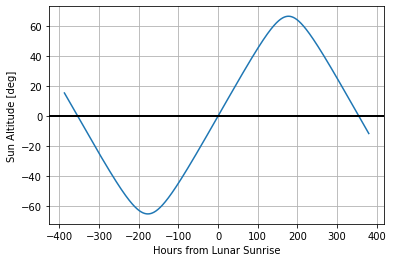

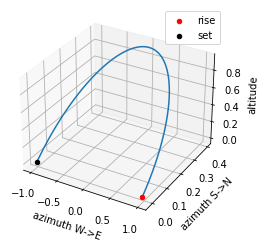

In [5]:
alt = np.loadtxt('alt_fullday.txt')
az = np.loadtxt('az_fullday.txt')
mjd = np.loadtxt('mjd_fullday.txt')

# transitions
iMidnight = np.argmin(alt)
iNoon = np.argmax(alt)
iSundown1 = np.argmin(np.abs(alt[:iMidnight]))
iSunrise = np.argmin(np.abs(alt[iMidnight:])) + iMidnight
iSundown2 = np.argmin(abs(alt[iNoon:])) + iNoon
hrsFromSunset = (mjd - mjd[iSundown1])*24
hrsFromSunrise = (mjd - mjd[iSunrise])*24
t_inc = 0.25 #Varies! But approx 0.25hrs ticks

alt_sun_top = np.asarray(alt)+0.265
iSuntoprise = np.argmin(np.abs(alt_sun_top[iMidnight:iNoon])) + iMidnight
iSuntopdown2 = np.argmin(abs(alt_sun_top[iNoon:])) + iNoon

# plot altitude through the cycle
plt.plot(hrsFromSunrise,alt, label='Alt')
plt.axhline(0, c='k', lw=2)
plt.grid(True)
plt.xlabel("Hours from Lunar Sunrise")
plt.ylabel("Sun Altitude [deg]")

# plot track of sun in 3D during 1 lunar day
plt.figure()
ax = plt.axes(projection='3d')
# day_mask = alt > 0
day_mask = [False]*len(alt) | (alt>0)
for i in range(len(day_mask)):
    if (i<iMidnight):
        day_mask[i] = False

sun = altaz2xyz(alt*np.pi/180, az*np.pi/180)
sunDay = altaz2xyz(alt*np.pi/180, az*np.pi/180)[day_mask]

ax.plot3D(sunDay[:,0],sunDay[:,1],sunDay[:,2])
ax.scatter3D(sunDay[0,0],sunDay[0,1],sunDay[0,2], c='r', label='rise')
ax.scatter3D(sunDay[-1,0],sunDay[-1,1],sunDay[-1,2], c='k', label='set')

ax.set_xlabel('azimuth W->E')
ax.set_ylabel('azimuth S->N')
ax.set_zlabel('altitude')
ax.legend()

### Lunar Surface Temperature   

Text(0.5, 1.0, 'Lunar Surface Temperature')

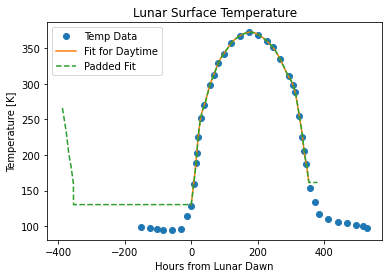

In [7]:
#Lunar surface temperature data
day_hrs = PVProjArea()[0]
hrs_per_lunar_day = 2551443/3600
temp_data = np.loadtxt("lunarTemperature30degDiviner.txt", delimiter=',') #Data starts at midnight!
time_hrs=(temp_data[:,0]-6)/24*hrs_per_lunar_day; temp=temp_data[:,1] #-6hrs to shift to hours from sunrise
temp_fit = interp1d(time_hrs,temp,kind='cubic')

# Interpolate temp data over daylight hours with same spacing as day_hrs
# Edge pad to length of day_hrs so array size/time increments match
# Power outside daylight hours will be zero'd by PVProjArea func, so thermal eff value meaningless outside daylight
time_day = np.arange(0,hrs_per_lunar_day/2,t_inc) 
temp_matched = np.pad(temp_fit(time_day),(iSunrise+1,len(day_hrs)-iSundown2+2), mode='edge') 
# Copy end of day temps to previous day
temp_matched[:iSundown1] = temp_matched[(iSundown2-iSundown1):iSundown2]

plt.plot(time_hrs,temp,'o', label='Temp Data')
plt.plot(time_day, temp_fit(time_day), '-', label='Fit for Daytime')
plt.plot(day_hrs, temp_matched, '--', label='Padded Fit')
plt.legend()
plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("Temperature [K]")
plt.title("Lunar Surface Temperature")


###  PV panel efficiency as function of temperature

In [6]:
# Parameters of SolAero IMM-beta panel LuSEE proposal
# Source: SolAero PFY23-00314 FFP for Lu-SEE Night project, 3/31/2023
# Top panel is 4 strings of 13 CICs; side panels are each 2 strings of 13
# Nominal BOL 20 degC AM0 normal incidence power at MPP is 137 W
# Solar constant times total cell area is 426.47 W
# BOL20_eff = 137/426.47 

# Return a parabolic fit to the three [power,temperature] given in the proposal
# include a 5% factor for manufacturing margin on BOL20
def pvEfficiency(T):
    pvTemp = np.array([-173.15, 20, 126.85])
    pvPwr = np.array([152, 130, 110]) / 426.47  # Stated AM0 normal incidence power output of top panel
    p = np.poly1d(np.polyfit(pvTemp, pvPwr, 2))
    return p(T)


Text(0.5, 1.0, 'SolAero IMM-beta space solar cell')

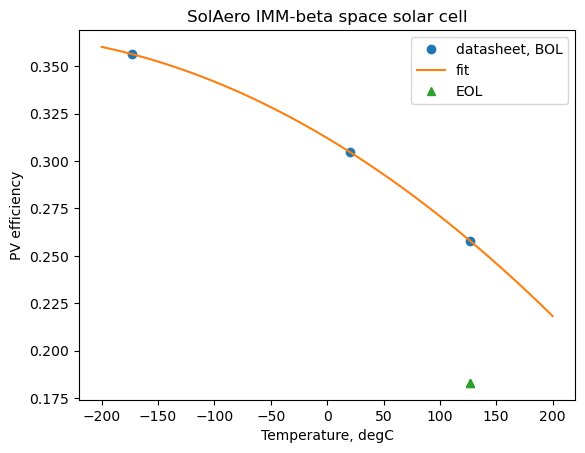

In [7]:
# test the efficiency-temperature function
plt.plot([-173.15, 20, 126.85], np.array([152, 130, 110]) / 426.47, 'o', label='datasheet, BOL')
plt.plot(np.linspace(-200,200,200), pvEfficiency(np.linspace(-200,200,200)), label='fit')
plt.plot([126.85, 126.85],[.183,.183], '^', label='EOL')
plt.xlabel('Temperature, degC')
plt.ylabel('PV efficiency')
plt.legend()
plt.title("SolAero IMM-beta space solar cell")

### Panel power output through one lunar cycle

PV average power = 111.93 W


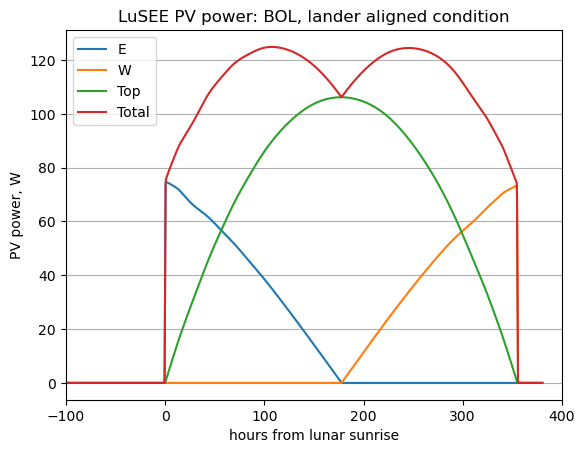

In [8]:
# Generate the time and projected area arrays
# day_hrs, EPV_projArea, WPV_projArea, TPV_projArea = PVPower(pv_tilt_angle=0,  \
    # lander_pitch=0, lander_roll=0, lander_yaw=0)

# Bring the padded surface temperature array found above
t_surface = temp_matched

# make an array of panel efficiencies assumeing they are at surface temperature
pvEffThermal = pvEfficiency(temp_matched - 273)

# panel parameters
solarConstant = 1361   # W/m^2 at Moon
TPV_area = .313        # m^2
EPV_area = TPV_area/2
WPV_area = TPV_area/2

# panel powers are product of projected area times efficiency
# ToDo: group geometric and loss/degradation parameters into 2 dicts and pass through
# ToDo: calculate pfEffThermal inside PVActualPower
# ToDo (future): individual panel temperatures when known
def PVActualPower(t_surface, EPV_area = .313/2, WPV_area = .313/2,TPV_area = .313, \
     solarConstant = 1361, horizon=0, pv_tilt_angle=0, \
     lander_pitch=0, lander_roll=0, lander_yaw=0, \
     dust_obscuration=0, shadowing=0, EOL_degradation=0):
    day_hrs, EPV_projArea, WPV_projArea, TPV_projArea = PVProjArea()
    cumInefficiencies = (1-dust_obscuration) * (1-shadowing) * (1-EOL_degradation)
    EPV_power = solarConstant * EPV_area * EPV_projArea * pvEffThermal * cumInefficiencies
    WPV_power = solarConstant * WPV_area * WPV_projArea * pvEffThermal * cumInefficiencies
    TPV_power = solarConstant * TPV_area * TPV_projArea * pvEffThermal * cumInefficiencies
    return EPV_power, WPV_power, TPV_power

# test
Epwr, Wpwr, Tpwr = PVActualPower(t_surface)
totPwr = Epwr + Wpwr + Tpwr
plt.plot(day_hrs, Epwr, label='E')
plt.plot(day_hrs, Wpwr, label='W')
plt.plot(day_hrs, Tpwr, label='Top')
plt.plot(day_hrs, totPwr, label='Total')
plt.legend()
plt.xlabel('hours from lunar sunrise')
plt.ylabel('PV power, W')
plt.grid(axis='y')
plt.xlim(-100,400)
plt.title("LuSEE PV power: BOL, lander aligned condition")

print(f"PV average power = {totPwr[iSunrise:iSundown2].mean():.2f} W")


### Simplified instrument power balance 
model:  
>night load = constant (Spectrometer operating, radio powered down)   
>day load = instrument + RF_RX + RF_TX + PPT + battery charging inefficiency  
>>- battery charger (PPT) cannot start until panel produces more than 10W
>>- RF radio off until panel produces more than 35W   
>>- battery begins to charge when panel power > instrument + RF radio  
>>- charging power = (panel power - instrument - RF radio) * charging efficiency   
>>- excess power (to be dumped) is panel power - day load


# Battery and PV panel parameters   

#### Night and day load parameters   

In [9]:
# All powers in W
PPT_power = 1.8     # Bradford, 5/30/2023 "May20_HibernationMode.pdf". Includes APR+BCR
PDU_power = 0.1     # Kotov
PFPS_power = 6      # Goetz
CDH_Power = 2       # Goetz
SPT_power = 9.25    # ET/JF/POC 5/23/2023 
Preamp_power = .86  # ET 5/23/2023
charging_efficiency = 0.95
discharge_efficiency = 0.95
uncertainty_margin = 0.1    # approximates NTE
nightPower = (PDU_power + PFPS_power + CDH_Power + SPT_power + Preamp_power) / (discharge_efficiency) \
     * (1 + uncertainty_margin)
print(f"Instrument power before losses and inefficiency "
f"{PDU_power +PFPS_power + CDH_Power + SPT_power + Preamp_power:.2f} W")
print(f"Night power {nightPower:.3f} W\n with discharge efficiency of {discharge_efficiency:.2f}\n \
and uncertainty margin of {uncertainty_margin: .2f}")


RF_RX_Power = 5.3
RF_TX_Power = 13.7       # per KG email 10/26/22 i.e. RX+TX mode is 19W

# LPF PARAMETERS (email from F. Davarian 6/24/22)
avePassInterval = 14.118    # hours
avePassDuration = 5.7       # hours
stdPassInterval = 2.4       # hours
stdPassDuration = 0.1       # hours
RX_TX_avePower = RF_RX_Power + RF_TX_Power * (avePassDuration / avePassInterval)     # RX remains on
print(f"\nRF TX average duty factor {avePassDuration/avePassInterval:.3f}, \
     \nAverage power {RX_TX_avePower/discharge_efficiency:.2f} W incl. discharge efficiency")


Instrument power before losses and inefficiency 18.21 W
Night power 21.085 W
 with discharge efficiency of 0.95
 and uncertainty margin of  0.10

RF TX average duty factor 0.404,      
Average power 11.40 W incl. discharge efficiency


### RESULTS

Cumulative Net Power During Daytime 25789.12W
Energy into Recharging Battery 7445.94Whrs
Excess Energy 18343.18Whrs
Average Load Power 27.48W
Minimum SOC 564.5Whrs  (8.2% of Full Charge)
Energy Deficit 0.00Whrs


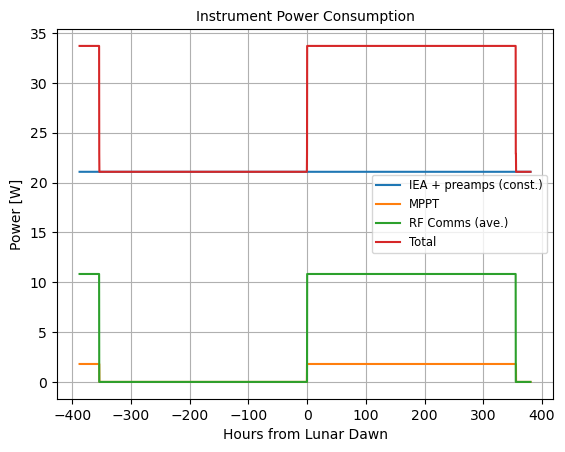

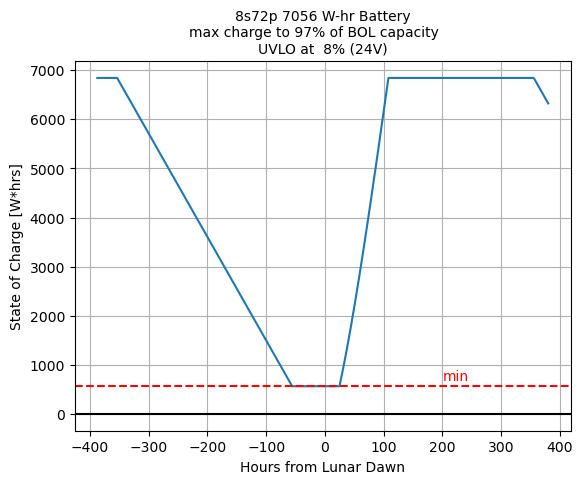

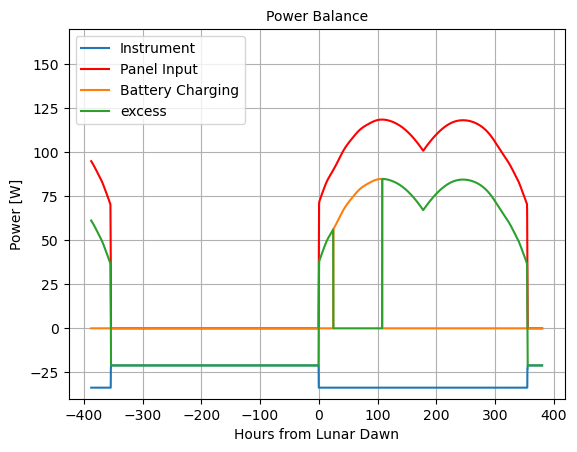

In [10]:
# Power input and output
# ToDo: stochastic radio TX power
Epwr, Wpwr, Tpwr = PVActualPower(t_surface)
panelPower = Epwr + Wpwr + Tpwr

PPT_threshold = 10              # panel power to awaken PPT
radio_threshold = 35            # panel power to awaken radio
charging_mask = (panelPower > PPT_threshold) 
radio_mask = (panelPower > radio_threshold) 

loadPower = nightPower + PPT_power * charging_mask + RX_TX_avePower * radio_mask
netPower = (panelPower*charging_mask*charging_efficiency)-loadPower  # power available to charge battery


# Plot the components of daytime power
plt.figure()
plt.plot(day_hrs, np.ones_like(day_hrs) * nightPower, label='IEA + preamps (const.)')
plt.plot(day_hrs, PPT_power*charging_mask, label = "MPPT")
plt.plot(day_hrs, RX_TX_avePower*radio_mask, label = "RF Comms (ave.)")
plt.plot(day_hrs, np.ones_like(day_hrs) * nightPower + PPT_power * charging_mask + RX_TX_avePower*radio_mask, label = "Total")
plt.grid(True); plt.legend(fontsize='small'); plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("Power [W]")
plt.title("Instrument Power Consumption", fontsize='medium')



# Calculate State of Charge
nameplateCapacity = 7056 # W-hrs, per ABSL-BNL8s72p 021623 FFP proposal 2/16/2023
maxCharge = .97         # need confirmation
maxDoD =    .08         # corresponds to 24V battery/3V cell voltage for Li-NMC
fullCharge = maxCharge * nameplateCapacity

# SOC
SOC = np.zeros(len(netPower))
SOC[0] = fullCharge # Start with battery full
excess_energy = 0
for index in range(len(netPower)-1):
    SOC[index+1] = min(SOC[index]+netPower[index]/4., fullCharge) # Don't overcharge battery
    if np.logical_and(index>iSunrise, SOC[index]+netPower[index]/4. > fullCharge):
        excess_energy = excess_energy + (SOC[index] + netPower[index]/4. - fullCharge)
SOC[SOC<maxDoD*nameplateCapacity] = maxDoD*nameplateCapacity
    

plt.figure()
plt.plot(day_hrs, SOC)
plt.grid(True); plt.xlabel('Hours from Lunar Dawn'); plt.ylabel("State of Charge [W*hrs]")
plt.title(f"8s72p 7056 W-hr Battery\nmax charge to {100*maxCharge:2.0f}% of BOL capacity\
    \nUVLO at {100*maxDoD:2.0f}% (24V)", fontsize='medium')
plt.axhline(0, c='k')
plt.text(200, 1.2*maxDoD*nameplateCapacity, 'min', color='r')
plt.axhline(maxDoD*nameplateCapacity, c='r',ls='dashed')

# Compute charging power
chargePower = np.diff(np.append(SOC, SOC[-1]))/.25
chargePower[:iSunrise] = 0
chargePower[iSundown2:] = 0

# Plot PV and load powers
fig, ax1 = plt.subplots()
ax1.plot(day_hrs, -1*loadPower, label='Instrument')
ax1.plot(day_hrs, panelPower*charging_mask*charging_efficiency, c='r', label='Panel Input')
ax1.plot(day_hrs, chargePower, label='Battery Charging')
ax1.plot(day_hrs, netPower - chargePower, label='excess')
plt.ylim(-40, 170)
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.set_xlabel('Hours from Lunar Dawn')
ax1.set_ylabel("Power [W]")
ax1.set_title("Power Balance", fontsize='medium')

#Stats
# print(f"Top area {TPV_area_working:.2f}m^2")
print(f"Cumulative Net Power During Daytime {netPower[iSuntoprise:iSuntopdown2].sum()/4.:.2f}W")
print(f"Energy into Recharging Battery {netPower[iSuntoprise:iSuntopdown2].sum()/4.-excess_energy:.2f}Whrs")
print(f"Excess Energy {excess_energy:.2f}Whrs")
print(f"Average Load Power {loadPower.mean():.2f}W")
print(f"Minimum SOC {SOC.min():.1f}Whrs  ({100*SOC.min()/fullCharge:.1f}% of Full Charge)")
print(f"Energy Deficit {fullCharge-SOC[iSundown2]:.2f}Whrs")

In [11]:
# # Plot lunar surface temp on the left y-axis
# fig, ax1 = plt.subplots()
# ax1.plot(day_hrs[iSunrise-96:], temp_matched[iSunrise-96:])
# ax1.set_xlabel('hours from lunar sunrise')
# ax1.set_ylabel('Lunar Surface Temperature [K]')
# # ax1.tick_params(axis='y')
# ax1.tick_params()
# ax1.grid(axis='x')

# # Create a second y-axis on the right side
# ax2 = ax1.twinx()

# # Plot the second dataset on the right y-axis
# ax2.plot(day_hrs[iSunrise-96:], pvEfficiency(temp_matched[iSunrise-96:]), color='r')
# ax2.set_ylabel('PV Efficiency', color='r')
# ax2.tick_params(axis='y', color='r')
# ax2.grid(True)
# plt.savefig('SurfaceTemp_PVefficiency.pdf')
